# Multi-instrument fitting

In this notebook, we will demonstrate `juliet`'s capability of simultaneously fitting multiple instruments with joint transit and eclipse model.

- Data used: WASP-18, TESS Sector 2 and 3 (Data can be found in the 'Data' folder)
- Model: Transit and Eclipse model
- `juliet` version: `dev` version of `juliet` for which the pull request is opened ([this](https://github.com/Jayshil/juliet/tree/dev) version)

First of all, let us import necessary packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import juliet
import os
import matplotlib.gridspec as gd
import astropy.units as u
import multiprocessing
multiprocessing.set_start_method('fork')

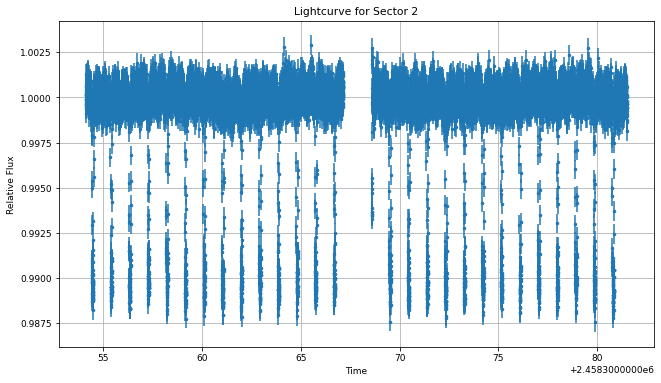

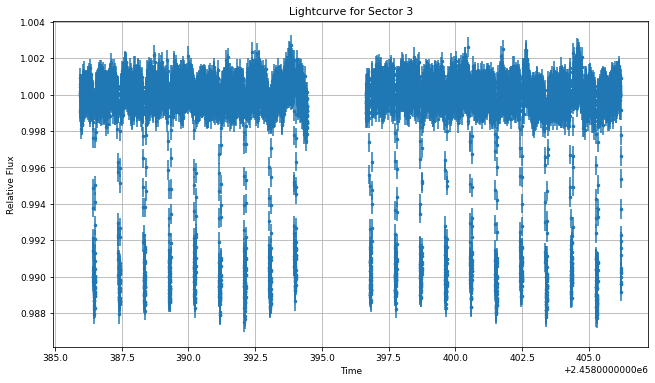

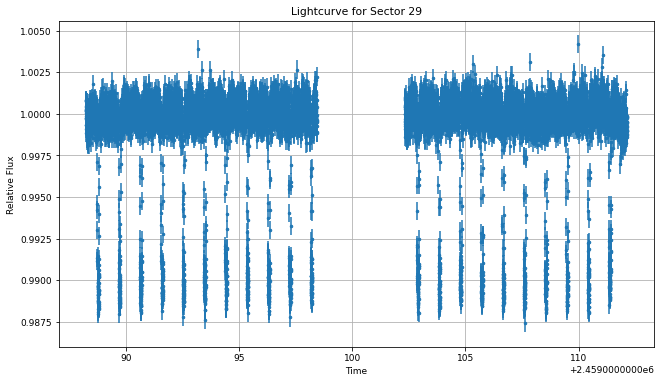

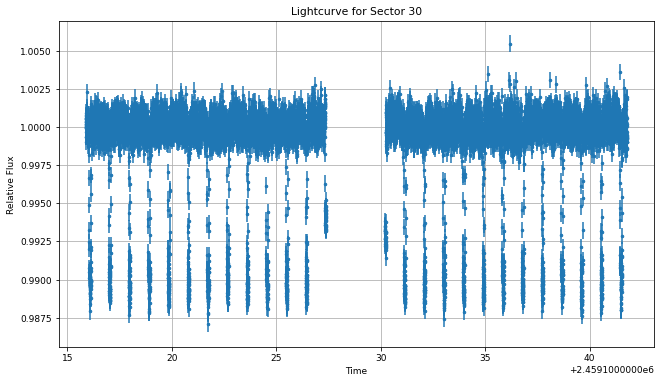

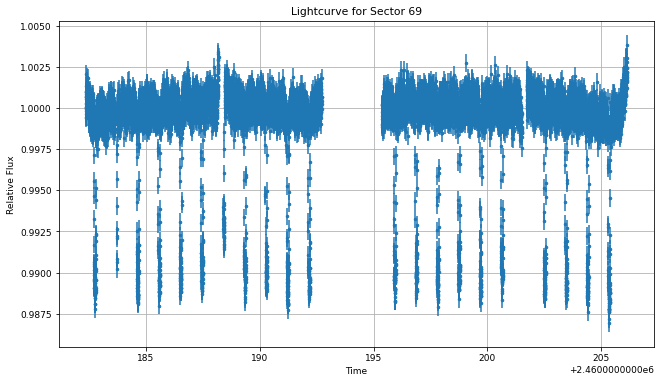

In [2]:
# Loading and storing the data the way juliet understands
instruments = ['TESS2', 'TESS3', 'TESS29', 'TESS30', 'TESS69']
tim, fl, fle = {}, {}, {}
for i in range(len(instruments)):
    tim7, fl7, fle7 = np.loadtxt(os.getcwd() + '/Data/WASP-18_' + instruments[i] + '.dat',\
                                 usecols=(0,1,2), unpack=True)
    tim[instruments[i]], fl[instruments[i]], fle[instruments[i]] = tim7, fl7, fle7

# And visualise the data
for i in tim.keys():
    plt.figure(figsize=(16/1.5, 9/1.5))
    plt.errorbar(tim[i], fl[i], yerr=fle[i], fmt='.')
    plt.xlabel('Time')
    plt.ylabel('Relative Flux')
    plt.title('Lightcurve for Sector ' + i[4:])
    plt.grid()
    plt.show()

The data looks nice! Transits of the planet is clearly visible.

Since, we are interested in fitting transit and eclipse, we would,
- Include priors on eclipse depth, `fp`
- Include LDCs.
- Note that `p` and `fp` both are now planetary _and_ instrumental parameters. And we have two instruments: TESS2 and TESS3. In the present examples, we keep the same planet-to-star radius ratio for both of the instruments. To do so, we will use `p_p1_TESS2_TESS3` in prior list.
- We do the same for the eclipse depth: we will use the same `fp_p1` for both instruments by using `fp_p1_TESS2_TESS3_TESS29_TESS30_TESS69` in the priors.
- Note also that while listing priors for `p` and `fp`, the planet number goes _before_ instrument. That means, `p_p1_TESS2` is valid, but `p_TESS2_p1` is not valid.
- In this example, we share `p_p1` for both instruments, but this is not necessary. One can provide different `p_p1` for both instruments. Same goes for `fp_p1`.
- Although `fp` is planetary _and_ instrumental parameter, the light travel correction factor is still _only_ planetary parameter, i.e., we will use `ac_p1`.

In [3]:
# Some planetary parameters (to provide priors)
# All parameters are taken from Cortés-Zuleta et al. 2020
per, per_err = 0.94145223, 0.00000024
bjd0, bjd0_err = 2456740.80560, 0.00019
rho, rho_err = ((0.795 * u.g/u.cm**3).to(u.kg/u.m**3)).value, \
     ((np.sqrt((0.110**2) + (0.089**2)) * u.g/u.cm**3).to(u.kg/u.m**3)).value
ecc, omega = 0.0091, 269   # From Shporer et al. (2018)

## Computing transit and eclipse time for the epoch from the data
cycle = round((tim[instruments[-1]][-1] - bjd0)/per)
tc1 = np.random.normal(bjd0, bjd0_err, 100000) + cycle*np.random.normal(per, per_err, 100000)
tc2 = tc1 + (np.random.normal(per, per_err, 100000)/2)

tc0, tc0_err = np.median(tc1), np.std(tc1)
tc02, tc02_err = np.median(tc2), np.std(tc2)

# And priros (Note that p and fp are planetary and instrumental parameters):
par_P = ['P_p1', 't0_p1', 'p_p1_' + '_'.join(instruments), 'b_p1',\
         'q1_' + '_'.join(instruments), 'q2_' + '_'.join(instruments), 'rho',\
         'fp_p1_TESS2_TESS3_TESS29_TESS30_TESS69',\
         't_secondary_p1', 'ecc_p1', 'omega_p1']
dist_P = ['normal', 'normal', 'uniform', 'uniform',\
          'uniform', 'uniform', 'normal',\
          'uniform',\
          'normal', 'fixed', 'fixed']
hyper_P = [[per, per_err], [tc0, tc0_err], [0., 1.], [0., 1.],\
           [0.,1.], [0.,1.], [rho, rho_err],\
           [0.e-6, 500.e-6],\
           [tc02, tc02_err], ecc, omega]

## Instrumental and GP parameters
par_ins, dist_ins, hyper_ins = [], [], []
for i in range(len(instruments)):
    par_ins = par_ins + ['mdilution_' + instruments[i], 'mflux_' + instruments[i], \
                         'sigma_w_' + instruments[i]]
    dist_ins = dist_ins + ['fixed', 'normal', 'loguniform']
    hyper_ins = hyper_ins + [1., [0., 0.1], [0.1, 10000.]]

par_gp, dist_gp, hyper_gp = [], [], []
for i in range(len(instruments)):
    par_gp = par_gp + ['GP_sigma_' + instruments[i], 'GP_timescale_' + instruments[i],\
                       'GP_rho_' + instruments[i]]
    dist_gp = dist_gp + ['loguniform', 'loguniform', 'loguniform']
    hyper_gp = hyper_gp + [[1e-5, 10000.], [1e-3, 1e2], [1e-3, 1e2]]

par_tot = par_P + par_ins + par_gp
dist_tot = dist_P + dist_ins + dist_gp
hyper_tot = hyper_P + hyper_ins + hyper_gp

priors_tot = juliet.utils.generate_priors(par_tot, dist_tot, hyper_tot)

In [4]:
# And fitting it!
dataset = juliet.load(priors=priors_tot, t_lc=tim, y_lc=fl, yerr_lc=fle,\
    GP_regressors_lc=tim, out_folder=os.getcwd() + '/Analysis/Multi-Transit-Eclipse_2')
res = dataset.fit(sampler = 'dynesty', nthreads=8)

56792it [7:34:15,  2.08it/s, +500 | bound: 745 | nc: 1 | ncall: 3010364 | eff(%):  1.903 | loglstar:   -inf < 464883.993 <    inf | logz: 464770.998 +/-  0.477 | dlogz:  0.001 >  0.509]


In [5]:
os.system("cat Analysis/Multi-Transit-Eclipse_2/posteriors.dat")

# Parameter Name     	 	 Median       	 	 Upper 68 CI  	 	 Lower 68 CI 
P_p1               	 	 0.9414524060 	 	 0.0000000239 	 	 0.0000000224
a_p1               	 	 3.4922252551 	 	 0.0142844962 	 	 0.0153487678
t0_p1              	 	 2460206.2947857594 	 	 0.0000353535 	 	 0.0000345050
p_p1_TESS2_TESS3_TESS29_TESS30_TESS69 	 	 0.0979193627 	 	 0.0001942473 	 	 0.0001950343
b_p1               	 	 0.3808897085 	 	 0.0116062730 	 	 0.0112274133
q1_TESS2_TESS3_TESS29_TESS30_TESS69 	 	 0.2275468173 	 	 0.0161427481 	 	 0.0158662019
q2_TESS2_TESS3_TESS29_TESS30_TESS69 	 	 0.2884359325 	 	 0.0309925544 	 	 0.0283429090
rho                	 	 908.9965547181 	 	 11.2001262030 	 	 11.9328354415
fp_p1_TESS2_TESS3_TESS29_TESS30_TESS69 	 	 0.0003740295 	 	 0.0000130086 	 	 0.0000130195
t_secondary_p1     	 	 2460206.7645828673 	 	 0.0003148285 	 	 0.0003154101
mflux_TESS2        	 	 0.0012949315 	 	 0.0030087273 	 	 0.0027477090
sigma_w_TESS2      	 	 1.7496269087 	 	 7.8911800725 	 	 1.4793100113

0


mflux_TESS3        	 	 -0.0027652171 	 	 0.0031398139 	 	 0.0035174983
sigma_w_TESS3      	 	 1.3637399373 	 	 9.5778694053 	 	 1.1258262237
mflux_TESS29       	 	 -0.0057545990 	 	 0.0034956031 	 	 0.0039838754
sigma_w_TESS29     	 	 206.0570391344 	 	 9.5088903999 	 	 9.7080769594
mflux_TESS30       	 	 0.0027731890 	 	 0.0035761103 	 	 0.0029804794
sigma_w_TESS30     	 	 178.2048845752 	 	 9.6268541638 	 	 9.8286980343
mflux_TESS69       	 	 0.0065789110 	 	 0.0047652197 	 	 0.0042669428
sigma_w_TESS69     	 	 2.8804188161 	 	 22.0809376487 	 	 2.5698713034
GP_sigma_TESS2     	 	 0.0000191438 	 	 0.0000228662 	 	 0.0000070758
GP_timescale_TESS2 	 	 0.0163012769 	 	 0.0095438978 	 	 0.0087769500
GP_rho_TESS2       	 	 55.3518955740 	 	 28.1009249694 	 	 23.6377945546
GP_sigma_TESS3     	 	 0.0000262063 	 	 0.0000432291 	 	 0.0000130525
GP_timescale_TESS3 	 	 0.0114833345 	 	 0.0114133830 	 	 0.0071153116
GP_rho_TESS3       	 	 56.1545412336 	 	 28.1843940556 	 	 25.1923235519
GP_sig

The posteriors look good for most of the planetary parameters and seems to agree with their corresponding values from the literature.

Let's now visualise our results to make sure that everything was smooth.

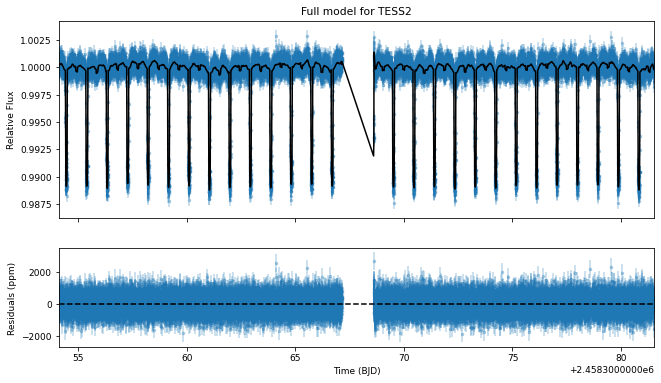

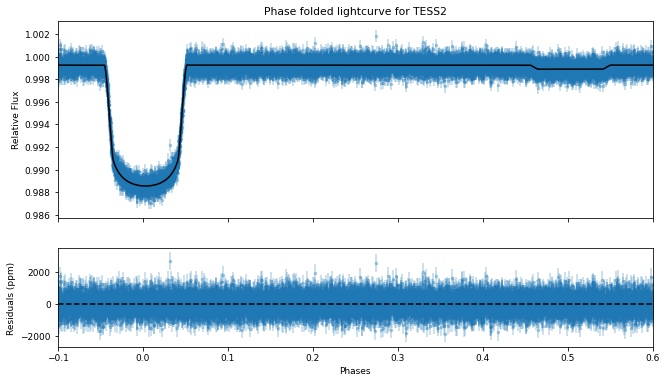

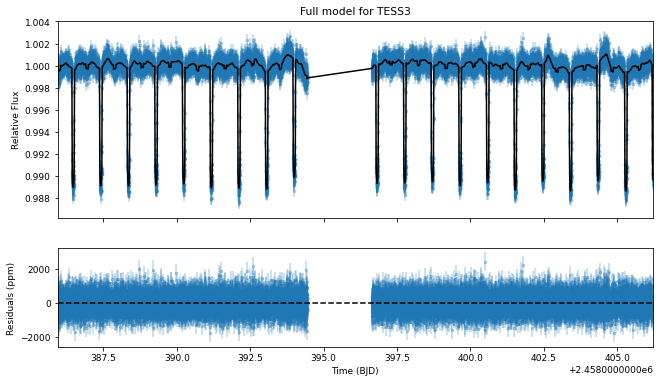

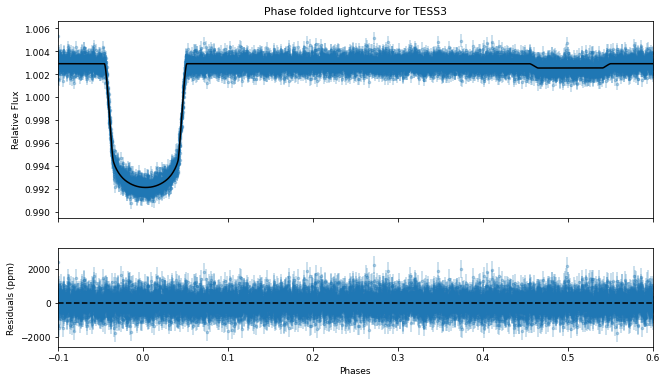

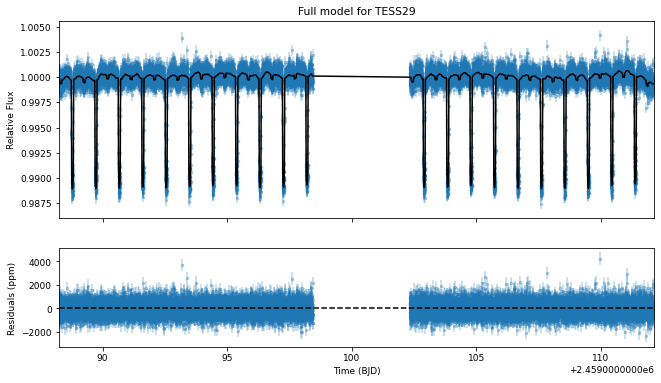

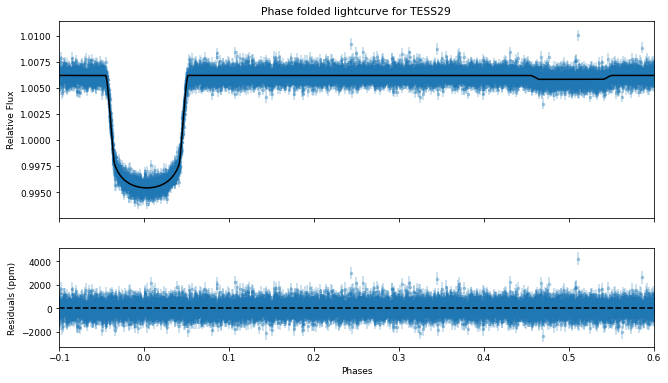

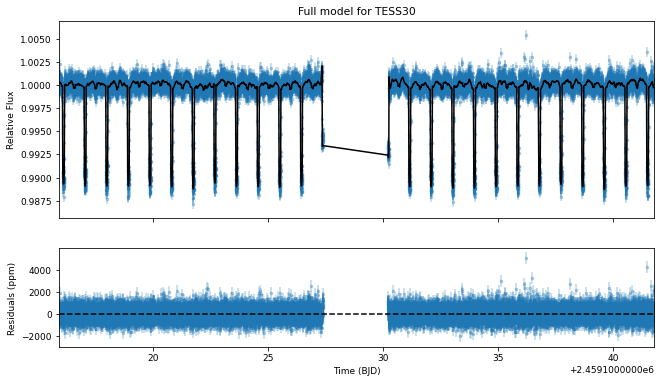

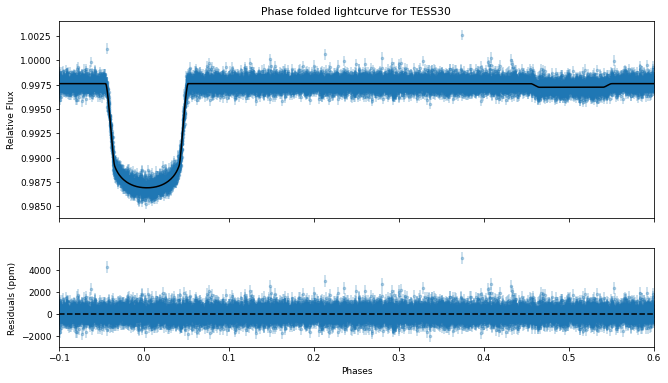

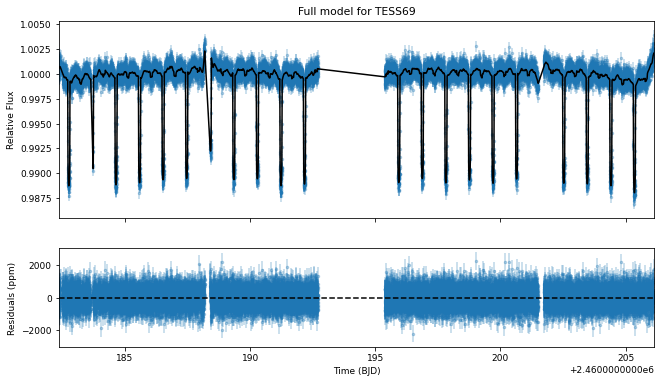

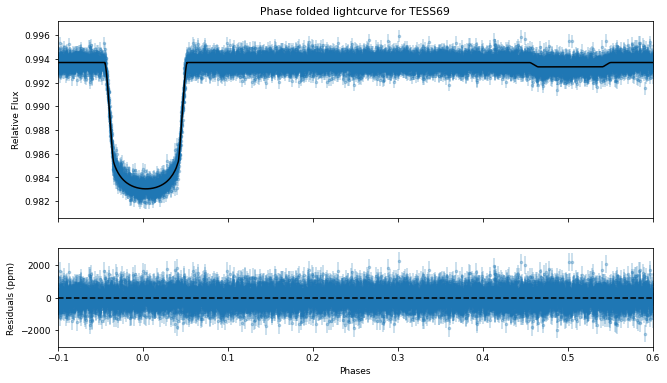

In [6]:
for i in tim.keys():
    # juliet best fit model
    model = res.lc.evaluate(i)
    gp_model = res.lc.model[i]['GP']
    transit_model = res.lc.model[i]['deterministic']
    # Making a plot
    fig = plt.figure(figsize=(16/1.5,9/1.5))
    gs = gd.GridSpec(2,1, height_ratios=[2,1])

    # Top panel
    ax1 = plt.subplot(gs[0])
    ax1.errorbar(tim[i], fl[i], yerr=fle[i], fmt='.', alpha=0.3)
    ax1.plot(tim[i], model, c='k', zorder=100)
    ax1.set_ylabel('Relative Flux')
    ax1.set_xlim(np.min(tim[i]), np.max(tim[i]))
    ax1.xaxis.set_major_formatter(plt.NullFormatter())

    # Bottom panel
    ax2 = plt.subplot(gs[1])
    ax2.errorbar(tim[i], (fl[i]-model)*1e6, yerr=fle[i]*1e6, fmt='.', alpha=0.3)
    ax2.axhline(y=0.0, c='black', ls='--', zorder=100)
    ax2.set_ylabel('Residuals (ppm)')
    ax2.set_xlabel('Time (BJD)')
    ax2.set_xlim(np.min(tim[i]), np.max(tim[i]))

    ax1.set_title('Full model for ' + i)
    plt.show()

    # Phase folded lightcurves:
    phs = juliet.utils.get_phases(tim[i], per, bjd0, phmin=0.8)
    idx = np.argsort(phs)
    # Making a plot
    fig = plt.figure(figsize=(16/1.5,9/1.5))
    gs = gd.GridSpec(2,1, height_ratios=[2,1])

    # Top panel
    ax1 = plt.subplot(gs[0])
    ax1.errorbar(phs, fl[i]-gp_model, yerr=fle[i], fmt='.', alpha=0.3)
    ax1.plot(phs[idx], transit_model[idx], c='k', zorder=100)
    ax1.set_ylabel('Relative Flux')
    ax1.set_xlim(-0.1, 0.6)
    #ax1.set_ylim(0.998, 1.002)
    ax1.xaxis.set_major_formatter(plt.NullFormatter())

    # Bottom panel
    ax2 = plt.subplot(gs[1])
    ax2.errorbar(phs, (fl[i]-model)*1e6, yerr=fle[i]*1e6, fmt='.', alpha=0.3)
    ax2.axhline(y=0.0, c='black', ls='--', zorder=100)
    ax2.set_ylabel('Residuals (ppm)')
    ax2.set_xlabel('Phases')
    ax2.set_xlim(-0.1, 0.6)

    ax1.set_title('Phase folded lightcurve for ' + i)
    plt.show()

This is fantastic!